In [1]:
pip install yfinance


In [15]:
import yfinance as yf
import pandas as pd

# Fetch Nifty 50 data
nifty_data = yf.download("^NSEI", start="2010-01-01", end="2020-01-01")  # Replace dates with your desired range

# Reset index to get 'Date' as a column
nifty_data.reset_index(inplace=True)

# Display the first few rows to verify the data
print(nifty_data.head())


[*********************100%***********************]  1 of 1 completed

        Date         Open         High          Low        Close    Adj Close  \
0 2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
1 2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2 2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
3 2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
4 2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

   Volume  
0       0  
1       0  
2       0  
3       0  
4       0  


In [16]:
# Check for missing values
print(nifty_data.isnull().sum())


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [17]:
# Fill missing values (example: forward fill)
nifty_data.fillna(method='ffill', inplace=True)


<ipython-input-17-2d3f7db6d003>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_data.fillna(method='ffill', inplace=True)


In [18]:
# Convert the 'Date' column to datetime format
nifty_data['Date'] = pd.to_datetime(nifty_data['Date'])


# Data fetch complete

moving average


In [19]:
# Calculate SMA and EMA for specified periods
sma_periods = [20, 50, 100]  # Example periods
ema_periods = [20, 50, 100]   # Example periods

for period in sma_periods:
    nifty_data[f'SMA_{period}'] = nifty_data['Close'].rolling(window=period).mean()

for period in ema_periods:
    nifty_data[f'EMA_{period}'] = nifty_data['Close'].ewm(span=period, adjust=False).mean()


In [20]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate RSI
nifty_data['RSI'] = calculate_rsi(nifty_data)


In [21]:
# Calculate MACD
nifty_data['EMA_12'] = nifty_data['Close'].ewm(span=12, adjust=False).mean()
nifty_data['EMA_26'] = nifty_data['Close'].ewm(span=26, adjust=False).mean()
nifty_data['MACD'] = nifty_data['EMA_12'] - nifty_data['EMA_26']
nifty_data['Signal_Line'] = nifty_data['MACD'].ewm(span=9, adjust=False).mean()


In [22]:
# Display the updated DataFrame with indicators
print(nifty_data.head())


        Date         Open         High          Low        Close    Adj Close  \
0 2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
1 2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2 2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
3 2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
4 2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

   Volume  SMA_20  SMA_50  SMA_100       EMA_20       EMA_50      EMA_100  \
0       0     NaN     NaN      NaN  5232.200195  5232.200195  5232.200195   
1       0     NaN     NaN      NaN  5236.552548  5233.992341  5233.105140   
2       0     NaN     NaN      NaN  5240.861811  5235.867143  5234.069391   
3       0     NaN     NaN      NaN  5242.979743  5236.935102  5234.644256   
4       0     NaN     NaN      NaN  5243.148339  5237.241569  5234.844370   

   RSI       EMA_12       EMA_26      MACD  Signal

# Normalaisng the data

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Select features for normalization (include OHLC and calculated indicators)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Signal_Line'] + \
            [f'SMA_{period}' for period in sma_periods] + \
            [f'EMA_{period}' for period in ema_periods]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
nifty_data[features] = scaler.fit_transform(nifty_data[features])


In [24]:
import numpy as np

# Define the function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps, 3])  # Assuming 'Close' is at index 3
    return np.array(X), np.array(y)

# Set the number of time steps (e.g., 30 days)
time_steps = 30

# Create sequences
X, y = create_sequences(nifty_data[features].values, time_steps)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], len(features)))


In [25]:
# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, {y_test.shape}')


Training data shape: (1930, 30, 14), (1930,)
Testing data shape: (483, 30, 14), (483,)


# **LSTM**

In [26]:
pip install tensorflow


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [28]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for the predicted Close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          13,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,251 (129.89 KB)

 Trainable params: 33,251 (129.89 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: nan - val_loss: nan
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: nan - val_loss: nan
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: nan - val_loss: nan
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: nan - val_loss: nan
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: nan - val_loss: nan
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: nan - val_loss: nan
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: nan - val_loss: nan
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: nan - val_loss: nan
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan - val_loss: nan
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: nan - val_loss: nan
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: nan - val_loss: nan
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: nan - val_loss: nan
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/st

In [30]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: nan
Test Loss: nan


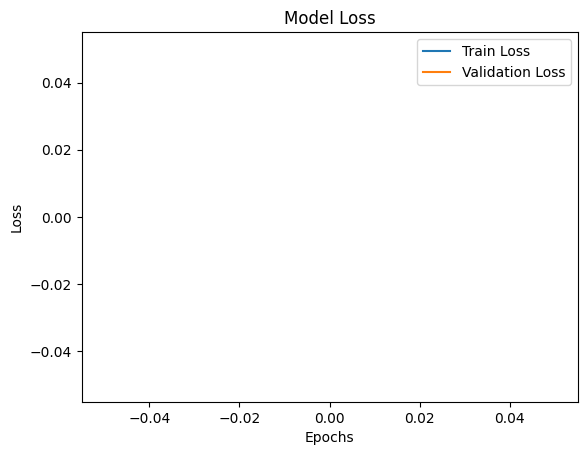

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# recheck

In [32]:
# Print the keys in the history object
print(history.history.keys())


dict_keys(['loss', 'val_loss'])


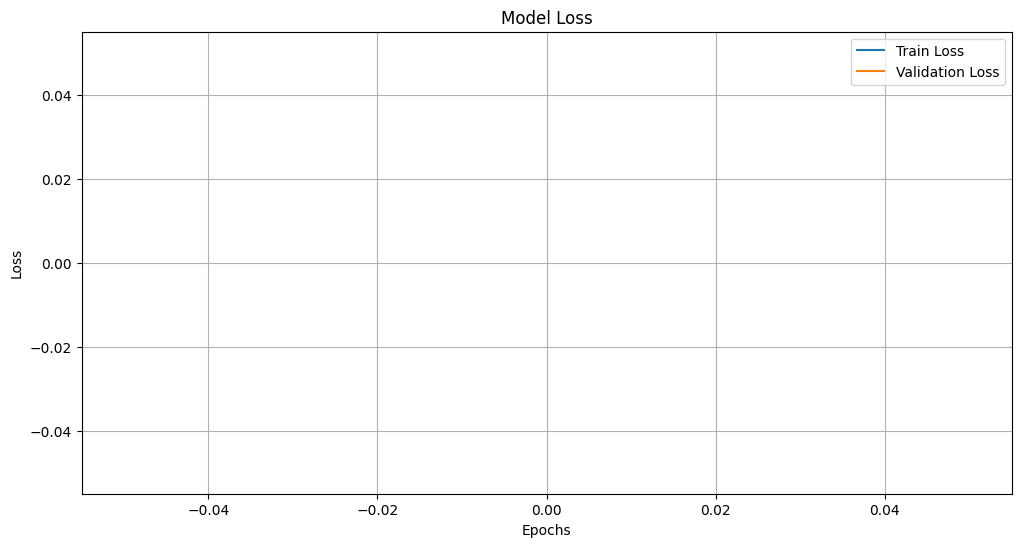

In [33]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
pip install matplotlib


In [35]:
%matplotlib inline


In [36]:
# Check the shape of the datasets
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (1930, 30, 14)
y_train shape: (1930,)
X_test shape: (483, 30, 14)
y_test shape: (483,)


In [37]:
# Check data types
print(f'X_train dtype: {X_train.dtype}')
print(f'y_train dtype: {y_train.dtype}')


X_train dtype: float64
y_train dtype: float64


In [38]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])  # Input sequence
        y.append(data[i + time_steps, 3])   # Assuming 'Close' is at index 3
    return np.array(X), np.array(y)

# Make sure to call it correctly
X, y = create_sequences(nifty_data[features].values, time_steps)


In [39]:
# Rebuild the model (if necessary)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: nan - val_loss: nan
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: nan - val_loss: nan
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan - val_loss: nan
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: nan - val_loss: nan
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: nan - val_loss: nan
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: nan - val_loss: nan
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: nan - val_loss: nan
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: nan - val_loss: nan
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: nan - val_loss: nan
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan - val_loss: nan
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: nan - val_loss: nan
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: nan - val_loss: nan
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/st

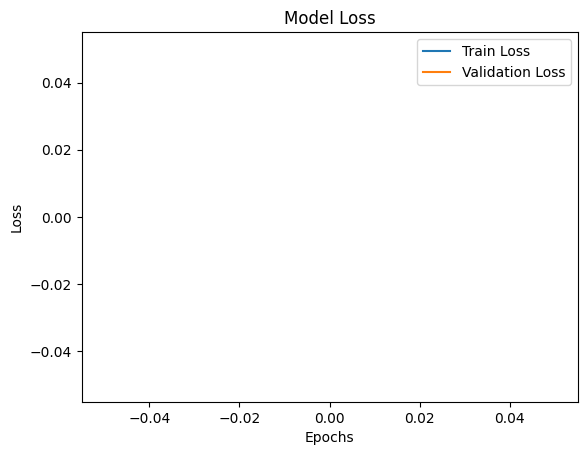

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# RETESTING AGAIN

In [41]:
import yfinance as yf
import pandas as pd

# Fetch Nifty 50 data
nifty_data = yf.download("^NSEI", start="2010-01-01", end="2020-01-01")  # Replace dates with your desired range
nifty_data.reset_index(inplace=True)

# Display the first few rows to verify the data
print(nifty_data.head())


[*********************100%***********************]  1 of 1 completed

        Date         Open         High          Low        Close    Adj Close  \
0 2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
1 2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2 2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
3 2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
4 2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

   Volume  
0       0  
1       0  
2       0  
3       0  
4       0  


In [42]:
# Check for missing values
print(nifty_data.isnull().sum())

# Handle missing values (forward fill or drop)
nifty_data.fillna(method='ffill', inplace=True)


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<ipython-input-42-2057a4bc3211>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_data.fillna(method='ffill', inplace=True)


In [43]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate indicators
sma_periods = [20, 50, 100]
ema_periods = [20, 50, 100]

for period in sma_periods:
    nifty_data[f'SMA_{period}'] = nifty_data['Close'].rolling(window=period).mean()

for period in ema_periods:
    nifty_data[f'EMA_{period}'] = nifty_data['Close'].ewm(span=period, adjust=False).mean()

nifty_data['RSI'] = calculate_rsi(nifty_data)

nifty_data['EMA_12'] = nifty_data['Close'].ewm(span=12, adjust=False).mean()
nifty_data['EMA_26'] = nifty_data['Close'].ewm(span=26, adjust=False).mean()
nifty_data['MACD'] = nifty_data['EMA_12'] - nifty_data['EMA_26']
nifty_data['Signal_Line'] = nifty_data['MACD'].ewm(span=9, adjust=False).mean()


In [44]:
print(nifty_data.head())

        Date         Open         High          Low        Close    Adj Close  \
0 2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
1 2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2 2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
3 2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
4 2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

   Volume  SMA_20  SMA_50  SMA_100       EMA_20       EMA_50      EMA_100  \
0       0     NaN     NaN      NaN  5232.200195  5232.200195  5232.200195   
1       0     NaN     NaN      NaN  5236.552548  5233.992341  5233.105140   
2       0     NaN     NaN      NaN  5240.861811  5235.867143  5234.069391   
3       0     NaN     NaN      NaN  5242.979743  5236.935102  5234.644256   
4       0     NaN     NaN      NaN  5243.148339  5237.241569  5234.844370   

   RSI       EMA_12       EMA_26      MACD  Signal

In [45]:
from sklearn.preprocessing import MinMaxScaler

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Signal_Line'] + \
            [f'SMA_{period}' for period in sma_periods] + \
            [f'EMA_{period}' for period in ema_periods]

scaler = MinMaxScaler()
nifty_data[features] = scaler.fit_transform(nifty_data[features])


In [46]:
import numpy as np

def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps, 3])  # Assuming 'Close' is at index 3
    return np.array(X), np.array(y)

time_steps = 30  # Use your preferred time steps
X, y = create_sequences(nifty_data[features].values, time_steps)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], len(features)))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [47]:
# Check for NaN values
print(f'NaN in X_train: {np.isnan(X_train).any()}')
print(f'NaN in y_train: {np.isnan(y_train).any()}')
print(f'NaN in X_test: {np.isnan(X_test).any()}')
print(f'NaN in y_test: {np.isnan(y_test).any()}')


NaN in X_train: True
NaN in y_train: False
NaN in X_test: False
NaN in y_test: False


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: nan - val_loss: nan
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: nan - val_loss: nan
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: nan - val_loss: nan
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: nan - val_loss: nan
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: nan - val_loss: nan
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: nan - val_loss: nan
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: nan - val_loss: nan
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: nan - val_loss: nan
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan - val_loss: nan
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: nan - val_loss: nan
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: nan - val_loss: nan
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: nan - val_loss: nan
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 

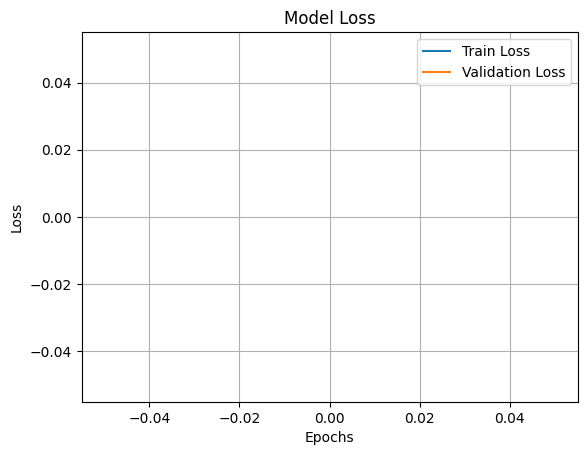

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# Forward fill to handle missing values
nifty_data.ffill(inplace=True)


In [51]:
# Check for missing values
print(nifty_data.isnull().sum())

# Forward fill to handle missing values
nifty_data.ffill(inplace=True)


Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
SMA_20         19
SMA_50         49
SMA_100        99
EMA_20          0
EMA_50          0
EMA_100         0
RSI            13
EMA_12          0
EMA_26          0
MACD            0
Signal_Line     0
dtype: int64
